In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import urllib

In [ ]:
targets = torch.randint(low=0, high=3, size=(10,))
logits =  torch.randn(10,3)

In [ ]:
print(targets)
print(logits)

tensor([1, 1, 2, 1, 1, 1, 2, 2, 0, 2])
tensor([[ 1.1336,  0.1123,  1.6933],
        [-1.4819,  0.7255,  0.0258],
        [-0.8469, -0.5635, -0.9364],
        [ 0.0588, -1.0476, -0.1046],
        [ 1.4285,  1.7204, -0.4946],
        [ 0.9659,  0.1821,  0.5610],
        [-0.0805, -0.5729, -0.9031],
        [ 0.0771, -1.5075, -1.2268],
        [ 0.4172,  2.2431, -0.2387],
        [-1.2035,  1.2742,  0.3576]])


In [ ]:
logits.shape, targets.shape

(torch.Size([10, 3]), torch.Size([10]))

In [ ]:
criterion = nn.CrossEntropyLoss()
loss = criterion(logits, targets)

In [ ]:
loss.item()

1.4527277946472168

In [ ]:
# Text to tokenids
def text_to_tokenids(text, tokenizer):
  tok_ids = tokenizer.encode(text)
  token_ids = torch.tensor(tok_ids).unsqueeze(0) # add batch dim
  return token_ids

# Tokenids to text
def tokenids_to_text(tokenids, tokenizer):
  text = tokenizer.decode(tokenids.squeeze(0).tolist()) #remove batch dim
  return text

# Calculating Cross Entropy loss between predicted vs target.

In [ ]:
from sample_data.model_components_all import GPTModel
import tiktoken
import torch

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size"  : 50257,
    "context_len" : 3,#256,
    "embd_dim"    : 768,
    "num_heads"   : 12,
    "num_layers"  : 12,
    "dropout_rate": 0.,
    "qkv_bias"    : False,
}


In [ ]:
inp1 = "Every effort moves"
target1 = " effort moves you"

inp2 = "I really like"
target2 = " really like chocolate"

In [ ]:
#Encode the inputs and targets.
tokenizer = tiktoken.get_encoding("gpt2")
tok_ids_i1 = (tokenizer.encode(inp1))
tok_ids_i2 = (tokenizer.encode(inp2))

tok_ids_t1 = (tokenizer.encode(target1))
tok_ids_t2 = (tokenizer.encode(target2))

#Stack-up
tok_ids_inp = [tok_ids_i1,tok_ids_i2]
tok_ids_tar = [tok_ids_t1,tok_ids_t2]

tok_ids_inp = torch.tensor(tok_ids_inp) #input tokens
tok_ids_tar = torch.tensor(tok_ids_tar) #target tokens

In [ ]:
model = GPTModel(cfg=GPT_CONFIG_124M)

with torch.no_grad():
  logits = model(tok_ids_inp)
logits.shape

torch.Size([2, 3, 50257])

# Manual Cross Entropy steps


In [ ]:
#Convert logits to probabilities using Softmax
probas = torch.softmax(logits, dim=-1)
probas.shape

torch.Size([2, 3, 50257])

In [ ]:
predicts = [torch.argmax(inp, dim=-1,keepdim=True) for inp in probas]
targets = [torch.argmax(tar, dim=-1,keepdim=True) for tar in tok_ids_tar]
predicts

[tensor([[13168],
         [ 1418],
         [38413]]),
 tensor([[28146],
         [39300],
         [24978]])]

In [ ]:
print("Target : ",tokenids_to_text(tok_ids_tar[0].T,tokenizer))
print("Predict: ",tokenids_to_text(predicts[0].T,tokenizer))

Target :   effort moves you
Predict:  ryption untBeaut


In [ ]:
tok_ids_tar[0]

tensor([3626, 6100,  345])

In [ ]:
# Get the probas for the target ids from the model output.
batch=0
tar_probs_1 = probas[batch, [0,1,2], tok_ids_tar[batch]]
batch=1
tar_probs_2 = probas[batch, [0,1,2], tok_ids_tar[batch]]


In [ ]:
log_probas = torch.log(torch.cat((tar_probs_1,tar_probs_2)))

In [ ]:
log_probas

tensor([-11.2788, -10.7478, -10.5804, -10.6210, -10.7203, -11.0265])

In [ ]:
-1*log_probas.mean()

tensor(10.8291)

In [ ]:
logits.squeeze(0)

tensor([[[ 0.6290,  0.2026,  1.1927,  ..., -0.4135, -0.4656,  0.5443],
         [-0.4868,  0.4808, -0.5867,  ...,  0.3814,  0.2915,  0.4500],
         [-0.3648,  0.0069, -0.0536,  ...,  0.5303,  0.7607,  0.0371]],

        [[-0.1009, -0.1674,  0.5672,  ..., -0.8395,  0.7193,  0.3040],
         [-0.0204,  0.6211,  0.0975,  ...,  0.3039, -0.1677, -0.1383],
         [ 0.2885, -0.2466, -0.5016,  ...,  0.6695,  0.2831,  0.3563]]])

## **#Cross Entropy**

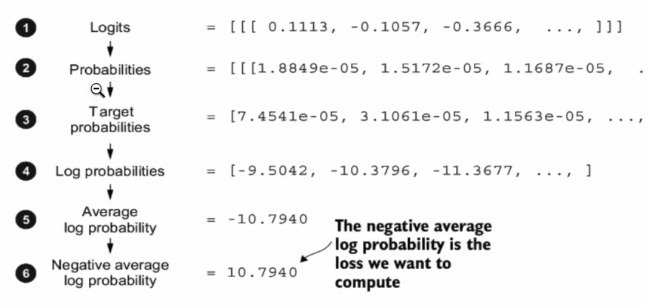

In [ ]:
print(logits.shape, tok_ids_tar.shape)
print("After flatten ------")
print(logits.flatten(0,1).shape, tok_ids_tar.flatten(0,1).shape)

torch.Size([2, 3, 50257]) torch.Size([2, 3])
After flatten ------
torch.Size([6, 50257]) torch.Size([6])


In [ ]:
torch.nn.functional.cross_entropy(logits.flatten(0,1),tok_ids_tar.flatten(0,1))

tensor(10.8291)

# ###** Training and Evaluation of Verdict dataset**

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size"  : 50257,
    "context_len" : 256,
    "embd_dim"    : 768,
    "num_heads"   : 12,
    "num_layers"  : 12,
    "dropout_rate": 0.,
    "qkv_bias"    : False,
}

In [ ]:
import os
import urllib
from sample_data.model_components_all import create_loader

context_len = GPT_CONFIG_124M["context_len"]
stride  = context_len
batch_size = 1

if not os.path.exists('verdict.txt'):
  url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch02/01_main-chapter-code/the-verdict.txt"
  file_path = "sample_data/verdict.txt"
  urllib.request.urlretrieve(url,file_path)

with open('./sample_data/verdict.txt','r',encoding='utf8') as F:
  raw_data = F.read()

dataloader,tkn = create_loader(raw_data, batch_size=batch_size,
                                context_len=context_len,
                                stride=stride,
                                num_workers=0, shuffle=True)

data = iter(dataloader)
''.join([ tkn.decode(next(data)[0][0]) for ii in range(0,1) ])

batch_size=1,context_len=256, stride=256,shuffle=True,  num_workers=0


' current could never have learned that mighty up-stream stroke. . . .\n\n"I turned back to my work, and went on groping and muddling; then I looked at the donkey again. I saw that, when Stroud laid in the first stroke, he knew just what the end would be. He had possessed his subject, absorbed it, recreated it. When had I done that with any of my things? They hadn\'t been born of me--I had just adopted them. . . .\n\n"Hang it, Rickham, with that face watching me I couldn\'t do another stroke. The plain truth was, I didn\'t know where to put it--_I had never known_. Only, with my sitters and my public, a showy splash of colour covered up the fact--I just threw paint into their faces. . . . Well, paint was the one medium those dead eyes could see through--see straight to the tottering foundations underneath. Don\'t you know how, in talking a foreign language, even fluently, one says half the time not what one wants to but what one can? Well--that was the way I painted; and as he lay ther

In [ ]:
train_ix = int(0.9*len(raw_data))
train_data = raw_data[:train_ix]
eval_data = raw_data[train_ix:]

In [ ]:
print(len(train_data), len(eval_data))
print(len(train_data)+ len(eval_data))

18431 2048
20479


In [ ]:
train_loader,tkn = create_loader(train_data,batch_size=2,context_len=context_len,stride=stride,shuffle=True, drop_last=True,num_workers=0)
eval_loader,tkn = create_loader(eval_data,batch_size=2,context_len=context_len,stride=stride,shuffle=True, drop_last=True,num_workers=0)
model = GPTModel(cfg=GPT_CONFIG_124M)
#logits = model(train_batch)

batch_size=2,context_len=256, stride=256,shuffle=True,  num_workers=0
batch_size=2,context_len=256, stride=256,shuffle=True,  num_workers=0


In [ ]:
for i,(train,target) in enumerate(train_loader):
  print("Train ",{i},":", list(train.size()),list(target.shape))
for i,y in eval_loader:
  print("Eval:", i.shape, y.shape)


Train  {0} : [2, 256] [2, 256]
Train  {1} : [2, 256] [2, 256]
Train  {2} : [2, 256] [2, 256]
Train  {3} : [2, 256] [2, 256]
Train  {4} : [2, 256] [2, 256]
Train  {5} : [2, 256] [2, 256]
Train  {6} : [2, 256] [2, 256]
Train  {7} : [2, 256] [2, 256]
Train  {8} : [2, 256] [2, 256]
Eval: torch.Size([2, 256]) torch.Size([2, 256])


In [ ]:
#How to extract train and target tokesn from Dataloader

train_tokens=0
for train,target in train_loader:
  train_tokens += train.numel()
print(f"{train_tokens=}")

eval_tokens=0
for eval,target in eval_loader:
  eval_tokens += eval.numel()
print(f"{eval_tokens=}")
print("Total tokens = ", train_tokens+eval_tokens)

train_tokens=4608
eval_tokens=512
Total tokens =  5120


In [ ]:
total_loss = 0
with torch.no_grad():
  for train , target in train_loader:
    logits = model(train)
    #
    # train:  [2,256,50257] -> Flatten [512, 50257]
    # target: [2,256]      -> Flatten [512]
    #
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target.flatten())
    total_loss += loss.item()
    print("Loss: ",f"{loss.item()}")

Training_loss = total_loss/len(train_loader)

print("Training loss :", Training_loss)

Loss:  10.993485450744629
Loss:  11.022289276123047
Loss:  10.90867805480957
Loss:  10.981415748596191
Loss:  10.955816268920898
Loss:  11.02383041381836
Loss:  10.97799015045166
Loss:  10.967824935913086
Loss:  11.008512496948242
Training loss : 10.982204755147299


In [ ]:
#Perplexity : means the number of words/tokesn it is unable to predict correctly.
# in this case 52K, means almost unable to predict any word.

perplexity = torch.exp(torch.tensor([Training_loss]))
print(f"{perplexity=}")

perplexity=tensor([58818.0703])
